# MEE-SMA Q-law: GTO to GEO

One of the most common low-thrust many revolution transfer is to go from GTO to GEO. In this example, we make use of `pyqlaw` to construct this transfer. 

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import time 

import sys
sys.path.append("../../../")    # path to pyqlaw
import pyqlaw

We begin by defining our canonical scales and initial conditions. 

In [2]:
# initial and final elements: [a,e,i,RAAN,omega,ta]
LU = 42164.0
GM_EARTH = 398600.44
VU = np.sqrt(GM_EARTH/LU)
TU = LU/VU

rp_gto = 200 + 6378
ra_gto = 35786 + 6378
sma_gto = (rp_gto + ra_gto)/(2*LU)
ecc_gto = (ra_gto - rp_gto)/(ra_gto + rp_gto)
KEP0 = [sma_gto,ecc_gto,np.deg2rad(23),0,0,0]
KEPF = [1,0,np.deg2rad(3),0,0,0]

# spacecraft parameters
MU = 1000        # spacecraft wet mass, kg
tmax_si = 0.45   # spacecraft thrust, Newton
isp_si  = 1500   # spacecraft specific impulse, seconds
mdot_si = tmax_si/(isp_si*9.81)  # kg/s

# non-dimensional quantities
mass0 = 1.0
tmax = tmax_si * (1/MU)*(TU**2/(1e3*LU))
mdot = np.abs(mdot_si) *(TU/MU)
tmax, mdot

(0.0020070507277914697, 0.0004193687522487825)

Because GEO is circular and planar, Keplerian elements are not good representations for the Lyapunov controller due to the associated singularities. We will instead use the state representation based on modified equinoctial elements, but with the semilatus rectum replaced by semi-major axis:

$$
\boldsymbol{x} = [a,f,g,h,k,L]^T
$$

This set of orbital elements is called `mee_with_a` within `pyqlaw`. 
We will convert our initial Keplerian elements to this representation.

In [3]:
oe0 = pyqlaw.kep2mee_with_a(np.array(KEP0))
oeT = pyqlaw.kep2mee_with_a(np.array(KEPF))

We can now construct the Q-law problem object, making sure that we choose the appropriate `elements_type`. We also have a choice of `integrator`, where we can either choose:

- `"rk4"`: fixed-step 4th order Runge-Kutta, or
- `"rkf45"`: 4th order Runge-Kutta with 5th order step-size correction

In addition, by setting `use_sundman = True`, we are taking steps in terms of fixed angle (i.e. fixed anomaly) rather than time. This is particularly useful to decrease computational time (by reducing number of integration steps) without compromising the accuracy too much for highly elliptical orbits, where small time-steps are required near periapsis, while large time-steps can be used near apoapsis. 

For now, we will assume Keplerian dynamics, so we do not pass any `perturbations` (we set it to `None` - which is the default anyway).

In [4]:
prob = pyqlaw.QLaw(
    integrator="rk4", 
    elements_type="mee_with_a",
    verbosity=2,
    print_frequency=2000,
    use_sundman=True,
    perturbations=None,
)

We now "set" the problem, i.e. we assign it its initial and final conditions, initial mass, spacecraft engine parameters, etc. 
One important parameter to keep in mind is `woe` - this is the weights associated to each state (i.e. orbital elements) component within the Lyapunov function. A larger weight means that the controller will put higher emphasis on correcting this particular component. 

In [5]:
# setup problem
tf_max = 365.25 * 86400 / TU       # max time, in canonical scales
t_step = np.deg2rad(5)             # integration step, in angles
woe = [3.0, 1.0, 1.0, 1.0, 1.0]
prob.set_problem(oe0, oeT, mass0, tmax, mdot, tf_max, t_step,
    woe = woe)
prob.pretty()

Transfer:
  a  : 5.7800e-01 -> 1.0000e+00 (weight: 3.00)
  f  : 7.3009e-01 -> 0.0000e+00 (weight: 1.00)
  g  : 0.0000e+00 -> 0.0000e+00 (weight: 1.00)
  h  : 2.0345e-01 -> 2.6186e-02 (weight: 1.00)
  k  : 0.0000e+00 -> 0.0000e+00 (weight: 1.00)


### Time-optimal transfer

We can now solve for the transfer. We will begin by constructing a solution that will always be thrusting. In optimal control problem (OCP) jargon, this is a bang-bang (as opposed to bang-off-bang) solution, and is the control history found for time-optimal problems. Of course, we must keep in mind that we are not solving an OCP here, so the solution we will obtain is sub-optimal. 

In [6]:
# solve
prob.solve()
prob.pretty_results()


 iter   |  time      |  del1       |  del2       |  del3       |  del4       |  del5       |  el6        |
      0 |  1.039e-02 | -4.2198e-01 |  7.3010e-01 |  0.0000e+00 |  1.7726e-01 |  0.0000e+00 |  2.2018e-01 |
   2000 |  8.556e+01 | -3.2997e-01 |  6.5143e-01 |  2.9548e-03 |  1.0648e-01 |  2.6716e-04 |  1.7385e+02 |
   4000 |  1.988e+02 | -1.5165e-01 |  5.1410e-01 |  7.9024e-03 |  2.8773e-02 |  7.6590e-04 |  3.4895e+02 |
   6000 |  3.578e+02 | -4.3293e-03 |  5.4661e-02 |  9.5281e-03 |  9.5632e-04 |  1.7875e-05 |  5.2368e+02 |
Target elements successfully reached!
Exit code : 2
Converge  : True
Final state:
  a  : 1.0016e+00 (error: 1.6300e-03)
  f  : 7.5003e-04 (error: 7.5003e-04)
  g  : 8.9484e-03 (error: 8.9484e-03)
  h  : 2.6237e-02 (error: 5.1170e-05)
  k  : 2.2512e-05 (error: 2.2512e-05)
Transfer time : 374.1679349112323
Final mass    : 0.8430856600047729


We can now plot and visualize the results:

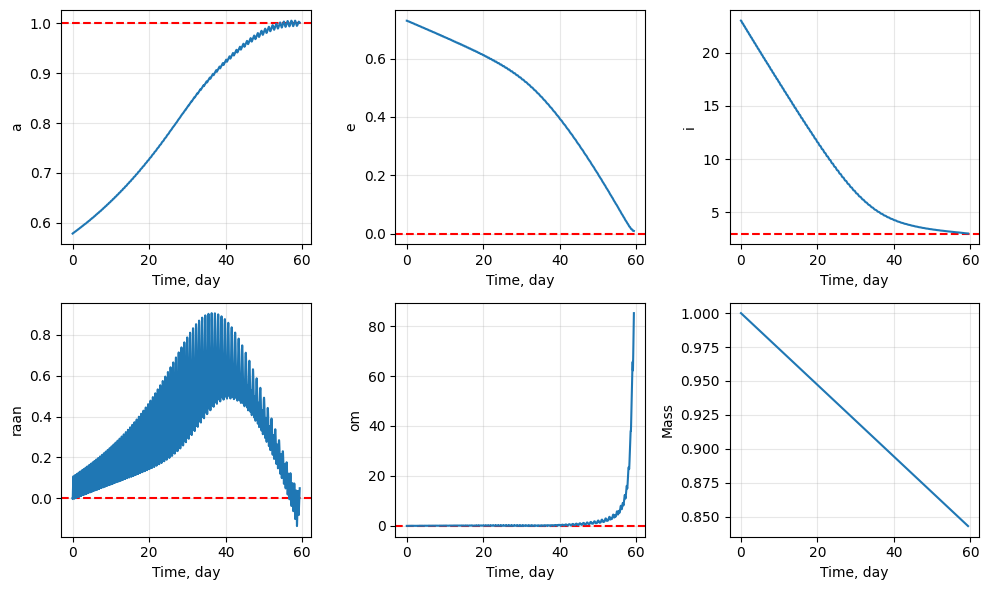

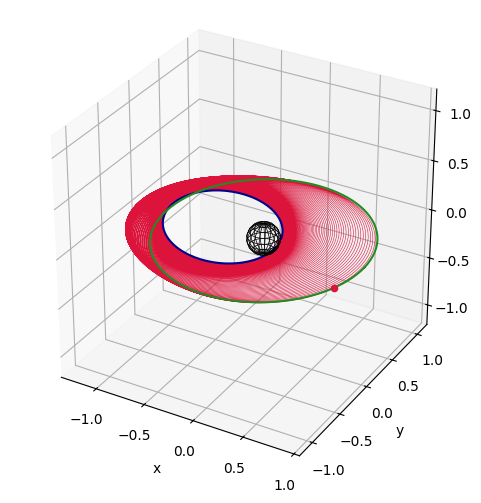

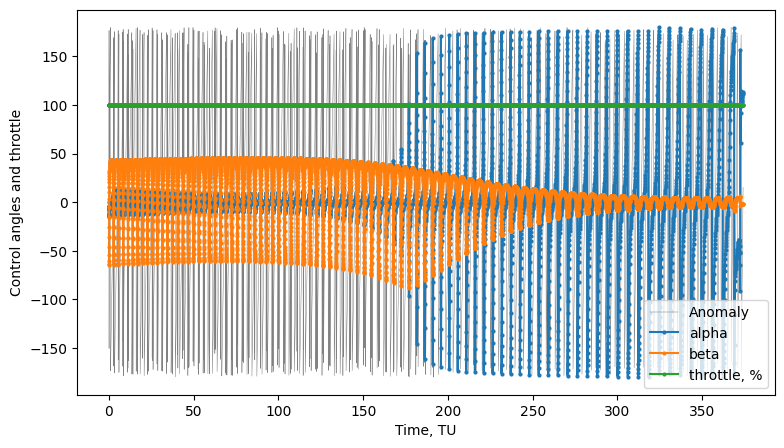

In [7]:
# plots
fig1, ax1 = prob.plot_elements_history(to_keplerian=True, TU=TU/86400, time_unit_name="day")
fig2, ax2 = prob.plot_trajectory_3d(interpolate=False, sphere_radius=6378/LU)
fig3, ax3 = prob.plot_controls()
plt.show()

### Introducing throttles

We can see in the third plot from the previous cell that the throttle is always at 100% - as expected. We can now introduce efficiency thresholds when we call the `solve()` method, (potentially) resulting in mass savings. 
It's important to remember that introducing efficiency thresholds does not necessarily mean mass savings in all cases - because we thrust less often, it will always take longer to reach the final targeted elements - and the fact that it takes longer also means we will be thrusting for longer duration in total, thus resulting in more mass expenditure. 

In [8]:
# solve
prob.solve(eta_r=0.1)
prob.pretty_results()


 iter   |  time      |  del1       |  del2       |  del3       |  del4       |  del5       |  el6        |
      0 |  1.039e-02 | -4.2200e-01 |  7.3009e-01 |  0.0000e+00 |  1.7727e-01 |  0.0000e+00 |  2.2018e-01 |
   2000 |  8.294e+01 | -3.5933e-01 |  6.4549e-01 |  2.1381e-03 |  1.1156e-01 |  3.2793e-04 |  1.7386e+02 |
   4000 |  1.823e+02 | -2.5229e-01 |  5.2796e-01 |  5.1523e-03 |  4.8240e-02 |  8.6583e-04 |  3.4895e+02 |
   6000 |  3.221e+02 | -1.7233e-02 |  2.7381e-01 |  5.3927e-03 |  7.4958e-03 |  5.8290e-04 |  5.2386e+02 |
Target elements successfully reached!
Exit code : 2
Converge  : True
Final state:
  a  : 9.9869e-01 (error: 1.3097e-03)
  f  : 4.9806e-03 (error: 4.9806e-03)
  g  : 9.5195e-03 (error: 9.5195e-03)
  h  : 2.6321e-02 (error: 1.3546e-04)
  k  : 2.1832e-04 (error: 2.1832e-04)
Transfer time : 423.3620208477802
Final mass    : 0.8587594862776317


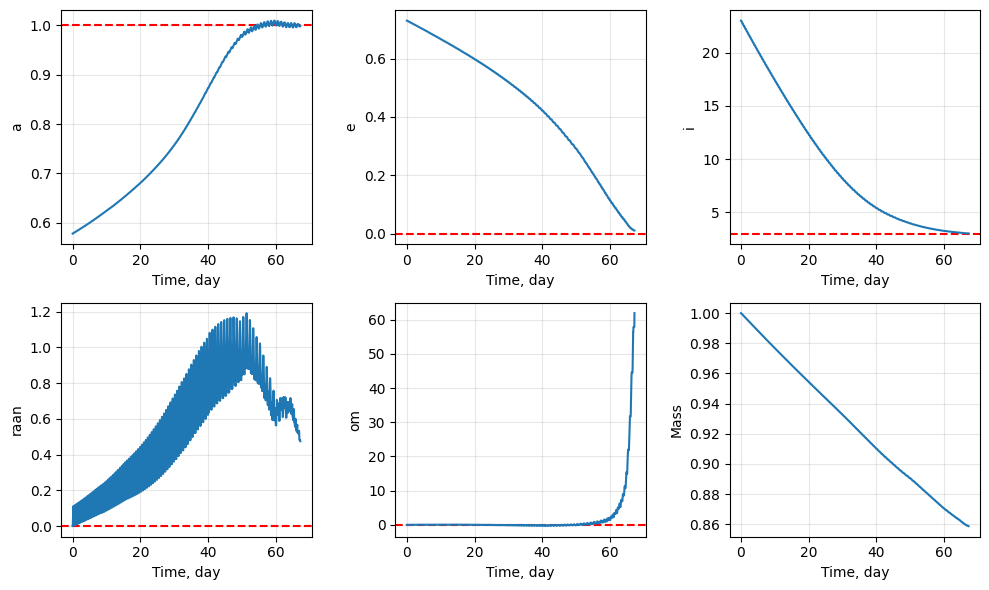

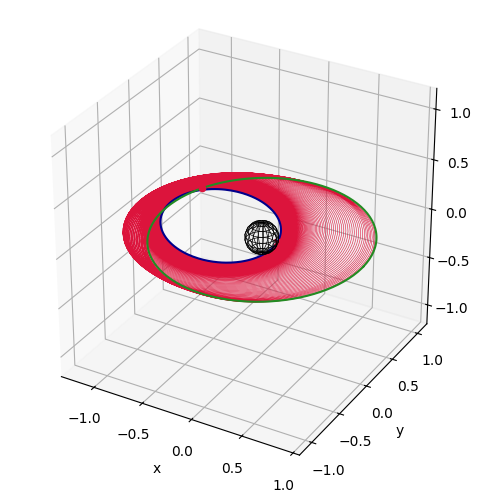

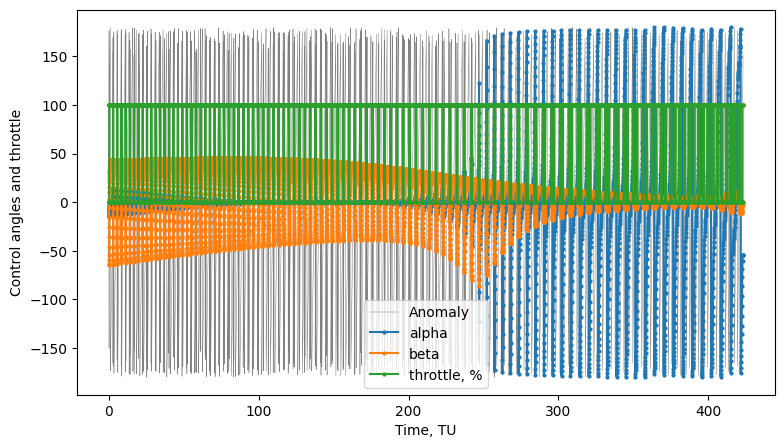

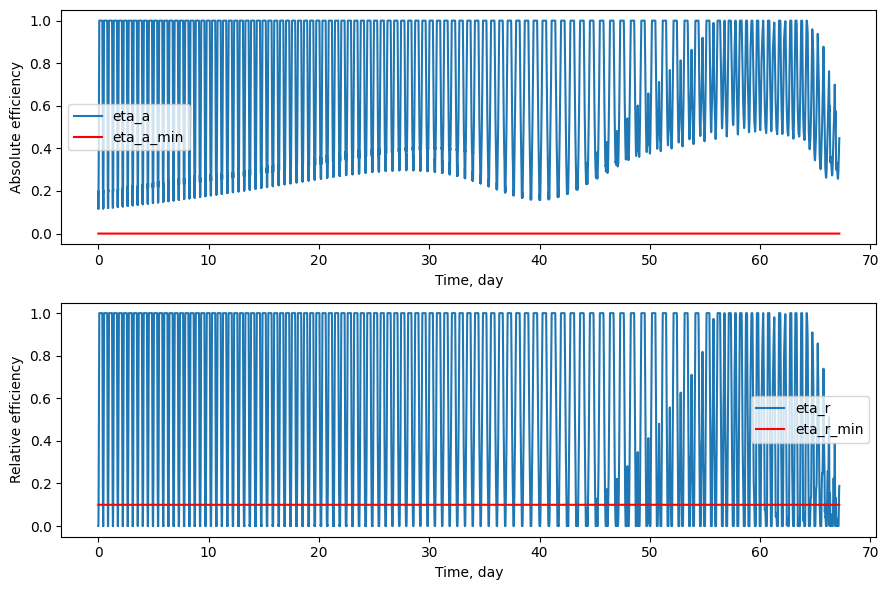

In [9]:
# plots
fig1, ax1 = prob.plot_elements_history(to_keplerian=True, TU=TU/86400, time_unit_name="day")
fig2, ax2 = prob.plot_trajectory_3d(interpolate=False, sphere_radius=6378/LU)
fig3, ax3 = prob.plot_controls()
fig4, ax4 = prob.plot_efficiency(TU=TU/86400, time_unit_name="day")
plt.show()

### Introducing Non-Keplerian perturbations

We will now consider non-Keplerian perturbations into our problem. This requires us to go back to the initialization of the `pyqlaw.QLaw` object. 

To compute perturbations, we require some SPICE kernels (to compute the position of the planets/Sun, as well as to compute the orientation of the principal axes frame with respect to the inertial frame. 

All kernels furnished (i.e. loaded) in the next cell can be downloaded on NAIF's website: https://naif.jpl.nasa.gov/pub/naif/generic_kernels/

In [10]:
import os
import spiceypy as spice
spice.furnsh(os.path.join(os.getenv("SPICE"), "lsk", "naif0012.tls"))
spice.furnsh(os.path.join(os.getenv("SPICE"), "spk", "de440.bsp"))
spice.furnsh(os.path.join(os.getenv("SPICE"), "pck", "gm_de440.tpc"))
spice.furnsh(os.path.join(os.getenv("SPICE"), "pck", "earth_200101_990825_predict.bpc"))
spice.furnsh(os.path.join(os.getenv("SPICE"), "fk", "earth_assoc_itrf93.tf"))

We can now construct the perturbations struct. As input, we need to also provide the initial epoch, i.e. the epoch which corresponds to time `t = 0` within the Q-law algorithm. 

In [11]:
# initialize object for perturbations
et_ref = spice.str2et("2028-01-01T00:00:00")   # seconds past J2000
perturbations = pyqlaw.SpicePerturbations(
    et_ref, LU, TU,
    frame_qlaw='J2000',
    J2=0.00108263,
)

We can now construct the problem object, making sure we pass `perturbations`

In [12]:
# construct problem with perturbations
prob = pyqlaw.QLaw(
    integrator="rk4", 
    elements_type="mee_with_a",
    verbosity=2,
    print_frequency=3000,
    use_sundman = True,
    perturbations = perturbations,
)

The remaining is the same as before - we `set_problem()`, then `solve()`!

In [13]:
prob.set_problem(oe0, oeT, mass0, tmax, mdot, tf_max, t_step,
    woe = woe)
prob.solve()
prob.pretty_results()


 iter   |  time      |  del1       |  del2       |  del3       |  del4       |  del5       |  el6        |
      0 |  1.039e-02 | -4.2198e-01 |  7.3010e-01 |  3.3846e-04 |  1.7726e-01 |  0.0000e+00 |  2.2019e-01 |
   3000 |  1.349e+02 | -2.6660e-01 |  5.9675e-01 |  4.8752e-02 |  6.9589e-02 | -1.5096e-02 |  2.6146e+02 |
   6000 |  3.525e+02 | -5.1307e-03 |  8.0411e-02 |  1.5217e-02 |  1.4554e-03 | -2.1631e-03 |  5.2384e+02 |
Target elements successfully reached!
Exit code : 2
Converge  : True
Final state:
  a  : 9.9797e-01 (error: 2.0346e-03)
  f  : -5.3929e-04 (error: 5.3929e-04)
  g  : 6.6768e-03 (error: 6.6768e-03)
  h  : 2.6244e-02 (error: 5.7777e-05)
  k  : 2.0926e-05 (error: 2.0926e-05)
Transfer time : 377.58390417496184
Final mass    : 0.8416531092369212


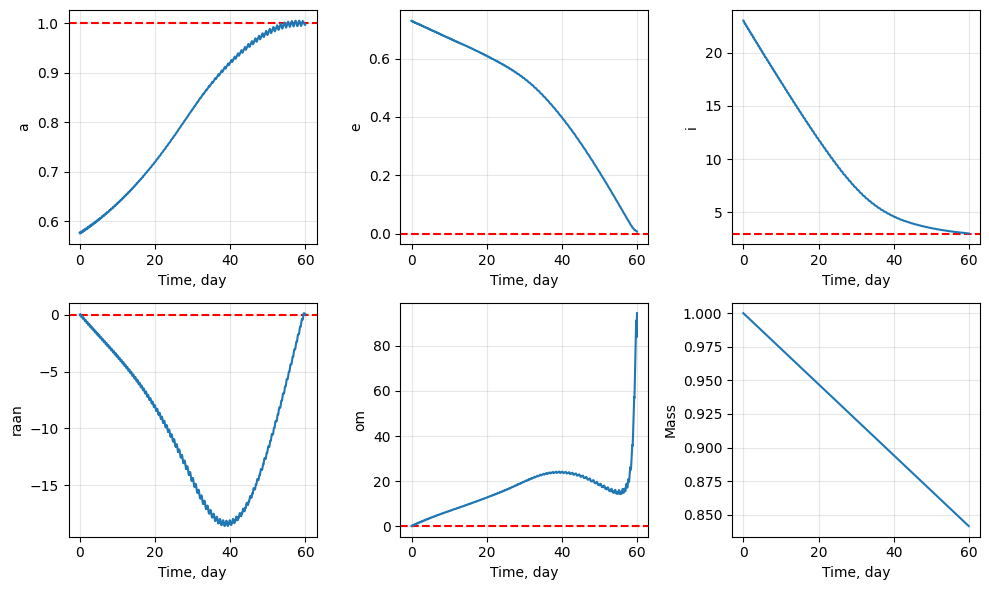

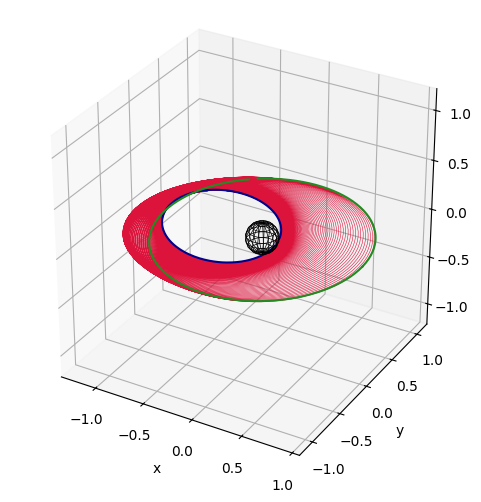

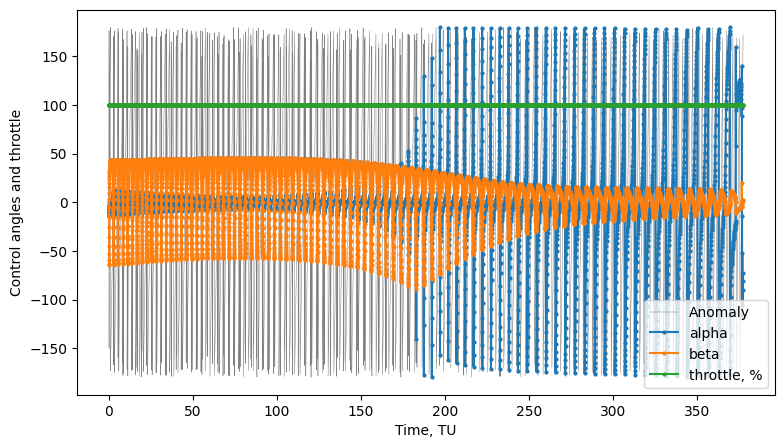

In [14]:
# plots
fig1, ax1 = prob.plot_elements_history(to_keplerian=True, TU=TU/86400, time_unit_name="day")
fig2, ax2 = prob.plot_trajectory_3d(interpolate=False, sphere_radius=6378/LU)
fig3, ax3 = prob.plot_controls()
plt.show()